# AthenaPK/Parthenon tutorial

This tutorial is provided as jupyter notebook (and mirrored here for easier access and initial instructions).

The tutorial itself is part of the **Towards exascale-ready astrophysics** workshop https://indico3-jsc.fz-juelich.de/event/169/ taking
place 25-27 Sep 2024 online.

The tutorial has been prepared by Philipp Grete <pgrete@hs.uni-hamburg.de> and is licensed under the BSD 3-Clause License.

In [1]:
# The PR for the Parthenon frontend in yt is still open, so we need to use a custom version, see https://github.com/parthenon-hpc-lab/athenapk?tab=readme-ov-file#data-analysis
# To accelerate the process, the package is already installed for the training but we need to make it known.
import sys
sys.path.insert(0, "/p/project1/training2437/tera_day1/yt")
import yt
yt.set_log_level(50) # disable logging

import matplotlib.pylab as plt
import numpy as np
import os
user = os.environ['USER']

from matplotlib.animation import FuncAnimation
from IPython.display import Video

# Step 0: Getting access

Follow instructions on how to get access https://gitlab.jsc.fz-juelich.de/hedgedoc/s/J-O7yP6hD#

# Step 1: Preparing the tutorial environment
Log in to https://jupyter-jsc.fz-juelich.de/

Fire up a lab environment (ideally do this during the coffee break as it might take some time) with
- Lab Config:
  - System: `JURECA`
  - Project: `training2437`
  - Partition: `dc-gpu`
- Resources (opens once `dc-gpu` is selected)
  - Nodes: `1`
  - GPUs: `4`
  - Runtime: `120` (or more if you want to continue after the offical timeslot
- Kernels and extensions: keep defaults

Once started open a terminal (which will run directly on the compute node) and execute the following to get the tutorial material
```bash
$ source /p/project1/training2437/tera_day1/setup_env.sh
```

Finally, navigate to the tutorial folder (`/p/project1/training2437/$USER/tera_day1/athenapk_tutorial`) on jupyter lab and open the notebook that's in the folder.

<div class="alert alert-block alert-info">
<b>Note:</b>
For a short discussion later (or on Slack) it might be useful to keep rough track of the code's performance for the various tests being run.
</div>

# Step 2: Building (not required for tutorial - just for reference)

Is machine dependent and (especially for device/GPU) might take some time.
Binaries to be run as part of the TERA24 tutorial were already prepared as follows.

```bash
$ module load Stages/2024 NVHPC OpenMPI CMake HDF5 Python Ninja
$ module load MPI-settings/CUDA

$ git clone https://github.com/parthenon-hpc-lab/athenapk.git
$ cd athenapk
# this will get the Parthenon and Kokkos sources that are build automatically
$ git submodule update --init

$ cmake -Bbuild-cuda-jureca -DKokkos_ENABLE_CUDA=ON -DKokkos_ARCH_AMPERE80=ON -DKokkos_ARCH_ZEN2=ON -DPARTHENON_DISABLE_HDF5_COMPRESSION=ON -DPARTHENON_ENABLE_PYTHON_MODULE_CHECK=OFF -GNinja
$ cmake --build build-cuda-jureca -j 8
```

Please get in touch if you run into troubles building on your own machine or cluster.
This particularly applies to the latter given that there are always machine specific details (also for running under batch systems like slurm).

Additional information:
- https://github.com/parthenon-hpc-lab/athenapk?tab=readme-ov-file#building-athenapk
- https://parthenon-hpc-lab.github.io/parthenon/develop/src/building.html

<div class="alert alert-block alert-info">
<b>Note:</b>
From here on the tutorial assumes that you're running the notebook on JUPYTER-JSC, use the visualization tools within the notebook, and execute the commands on the terminal opened within jupyter lab.

If you know your ways around JSC systems, you can, of course, also directly connect to the systems and/or use other visualization tools like ParaView or Visit.
</div>

# Step 3: Running 101

Note that all problem generators and solvers are always included in the binary and can be chosen at runtime through the input file.
This might be different from other common codes (including Athena++) where a binary is specifically built for a certain setup.

## First simulation (Kelvin-Helmholtz instability on a uniform grid)

### Run

On the terminal execute the simulation (we'll look at the input file `kh.in` and output while the simulation runs in the background).

```bash
# Loading modules is only required once
# Skip (already done by the setup_env.sh script above)
# module load Stages/2024 NVHPC OpenMPI CMake HDF5 Python
# module load MPI-settings/CUDA

$ cd /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_uniform
$ srun -n 1 ../bin/athenaPK -i kh.in |& tee ath.out
```

Given that we run interactively, we pipe the output to `ath.out` so that it's available later (for comparison).

### The input file

Let's take the input file apart.

In general, input files are split into blocks indicated by `<BLOCK_NAME>` where
`BLOCK_NAME` may also contain`/` to logically separate information.

The `<job>` block is mandatory for AthenaPK as it defines which problem generator to load.
These are typically connected to their respective source files in [`athenapk/src/pgen`](https://github.com/parthenon-hpc-lab/athenapk/tree/main/src/pgen).
```
<job>
problem_id = kh
```

Each problem generator typically comes with additonal parameters.
In AthenaPK it is customary to collect these parameters in the `<problem/PROBLEMNAME>` block, like
```
<problem/kh>
iprob  = 5               # AMR test setup from Athena++ method paper
vflow  = 1.0             # relative shear velocity of the interfaces
a      = 0.01            # thickness of shearing layer
drat   = 2               # density contrast/ratio
amp    = 0.01            # amplitude of initial vy perturbation
sigma  = 0.2             # thickness of perturbed layer
```

The overall mesh is configured within the `<parthenon/mesh>` block.
Note the `parthenon` prefix, which typically means that these inputs are controlled
by the [Parthenon](https://github.com/parthenon-hpc-lab/parthenon) framework
and additional information might be located in the Parthenon documentation, e.g., https://parthenon-hpc-lab.github.io/parthenon/develop/src/inputs.html

Here, we setup a uniform, static 2D grid with 512x512 cells and periodic boundary conditions.
```
<parthenon/mesh>
refinement = none
nghost = 2

nx1 = 512
x1min = -0.5
x1max = 0.5
ix1_bc = periodic
ox1_bc = periodic

nx2 = 512
x2min = -0.5
x2max = 0.5
ix2_bc = periodic
ox2_bc = periodic

nx3 = 1
x3min = -0.5
x3max = 0.5
ix3_bc = periodic
ox3_bc = periodic
```

The mesh itself it logically separate into (identical) meshblocks whose size is configured in the `<parthenon/meshblock>` block.
The size is fixed for all meshblocks and cannot be changed once the simulation has started.
Moreover, each active point in the simulation domain is covered by exactly one meshblock (this information is particularly relevant for simulations with mesh refinement).
All meshblocks communicate with each other via ghost/guard/halo cells (whose number is set in the `<parthenon/mesh>` block above.

Here, we pick a block size of 128x512, i.e., the mesh is split into 4 blocks total.
Picking the right block size is highly problem dependent and also connected to performance (see [101 on performance](step-4:-Performance-101)).
```
<parthenon/meshblock>
nx1=128
nx2=512
nx3=1
```

Parthenon also takes care of time integration, which is why the following block is also prefixed with `parthenon`.

The following block will use a predictor-corrector Van-Leer type integrator with a CFL of 0.4.
The simulation will run till time 1.2 (in code time units) and not be limited by the number of cylces performed (negative `nlim`).
```
<parthenon/time>
integrator = vl2
cfl = 0.4
tlim = 1.2
nlim = -1
```

The `<hydro>` block is specific to AthenaPK again, see https://github.com/parthenon-hpc-lab/athenapk/blob/main/docs/input.md for additional information.

Here, we choose an adiabatic equation of state with ratio of specific heats of 1.4.
Fluxes are calcuated using an HLLC Riemann solver with second-order, piecewise-linear reconstruction (in the primitive variables).
```
<hydro>
eos = adiabatic
riemann = hllc
reconstruction = plm
gamma = 1.4 # gamma = C_p/C_v
```

Finally, we define an output block (again controlled by Parthenon, see https://parthenon-hpc-lab.github.io/parthenon/develop/src/outputs.html for additional details.

Here, we pick the `rst` type, which translates to `restart` and allows to restart a simulation (and can also be read by standard postprocessing tools, see in the following).
Outputs are written every 0.1 time intervals.
<div class="alert alert-block alert-warning">
<b>Note:</b>
Outputs are overwritten without warning.
</div>

```
<parthenon/output0>
file_type = rst
dt = 0.1
```

The simulation should be done by now, so let's have a look at the output on the terminal.

### The terminal output

A typical output of an AthenaPK simulation (or more generally Parthenon-based simulation) will start with general information available within the code framework.

Bonus info: Parthenon provides flexible interfaces to create variables that are described through metadata and afterwards handled transparently (e.g., communicated), see https://parthenon-hpc-lab.github.io/parthenon/develop/src/interface/metadata.html
In this simulation so-called sparse variables (that are only allocated on a subset of blocks) or "swarms" (i.e., particles based variables/fields)
are not used but cell-centered variables (and their fluxes).

```
Starting up hydro driver
# Variables in use:
# Package: parthenon::resolved_state
# ---------------------------------------------------
# Variables:
# Name  Metadata flags
# ---------------------------------------------------
prim                      Cell,Provides,Real,Derived,Hydro,parthenon::resolved_state
cons                      Cell,Provides,Real,Independent,FillGhost,WithFluxes,Hydro,parthenon::resolved_state
bnd_flux::cons            Face,Provides,Real,Derived,OneCopy,Flux,parthenon::resolved_state
# ---------------------------------------------------
# Sparse Variables:
# Name  sparse id       Metadata flags
# ---------------------------------------------------
# ---------------------------------------------------
# Swarms:
# Swarm Value   metadata
# ---------------------------------------------------
```

Afterwards, the simulation actually starts.
For each cycle, the cycle number (`cycle`), current time (`time`), current timestep (`dt`), performance in total cell updates per
wallclock second (across all computing resources, `zone-cycles/wsec_step`), current simulation runtime in wallclock seconds (`wsec_total`),
and wallclock seconds for the current cycle (`wsec_step`) are printed.
Having performance numbers per cycles has turned out useful to gauge performance in simulations with varying load (like with adapative mesh refinement)
or to identify machine issues/variability.

```
Setup complete, executing driver...

cycle=0 time=0.0000000000000000e+00 dt=3.2952612821802183e-04 zone-cycles/wsec_step=0.00e+00 wsec_total=1.44e-01 wsec_step=2.40e+00
cycle=1 time=3.2952612821802183e-04 dt=3.2952539311580179e-04 zone-cycles/wsec_step=5.16e+06 wsec_total=1.94e-01 wsec_step=5.08e-02
cycle=2 time=6.5905152133382367e-04 dt=3.2952465716610244e-04 zone-cycles/wsec_step=2.55e+07 wsec_total=2.05e-01 wsec_step=1.03e-02
```

Finally, once the simulation is done an overview is printed.
Note that the total performance `zone-cycles/wallsecond` might be different from the per-cycle output as it is an aggregate number.
```
cycle=3865 time=1.1994642549437093e+00 dt=2.7515679713439601e-04 zone-cycles/wsec_step=3.10e+07 wsec_total=3.29e+01 wsec_step=8.46e-03
cycle=3866 time=1.1997394117408438e+00 dt=2.6058825915620254e-04 zone-cycles/wsec_step=3.10e+07 wsec_total=3.29e+01 wsec_step=8.46e-03
cycle=3867 time=1.2000000000000000e+00 dt=2.7515150765570855e-04 zone-cycles/wsec_step=1.29e+07 wsec_total=3.29e+01 wsec_step=2.03e-02

Driver completed.
time=1.20e+00 cycle=3867
tlim=1.20e+00 nlim=-1

walltime used = 3.29e+01
zone-cycles/wallsecond = 3.08e+07
```




### Plotting the results

Various options exists to plot AthenaPK output (or more generally, Parthenon-based codes), see https://github.com/parthenon-hpc-lab/athenapk?tab=readme-ov-file#data-analysis

We'll use yt (https://yt-project.org/) with the frontend for Partheon-based codes provided above.

In [2]:
# adapted from https://yt-project.org/doc/cookbook/complex_plots.html#time-series-movie
ts = yt.load(f"/p/project1/training2437/{user}/tera_day1/athenapk_tutorial/kh_2d_uniform/parthenon.out0.*.rhdf")

plot = yt.SlicePlot(ts[0], "z", ("gas", "density"))
plot.set_log(("gas", "density"), False)
plot.set_zlim(("gas", "density"), 0.8, 2.1)

fig = plot.plots[("gas", "density")].figure

# animate must accept an integer frame number. We use the frame number
# to identify which dataset in the time series we want to load
def animate(i):
    ds = ts[i]
    plot._switch_ds(ds)

animation = FuncAnimation(fig, animate, frames=len(ts))
animation.save("kh_2d_uniform.mp4")

Video("kh_2d_uniform.mp4", embed=True)

NB: yt is a powerful data analysis tool.

Many (derived) fields are readily available and standard plot modifcations are straightforward.

/p/project1/training2437/tera_day1/yt/yt/geometry/grid_geometry_handler.py:383: RuntimeWarning: ghost-zones interpolation/smoothing is not currently supported for Parthenon data.
  g = og.retrieve_ghost_zones(ngz, [], smoothed=True)
/p/project1/training2437/tera_day1/yt/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/p/project1/training2437/tera_day1/yt/yt/visualization/image_writer.py:269: RuntimeWarning: invalid value encountered in cast
  mapped = np.dstack([(np.interp(buff, x, v) * 255).astype("uint8") for v in lut])



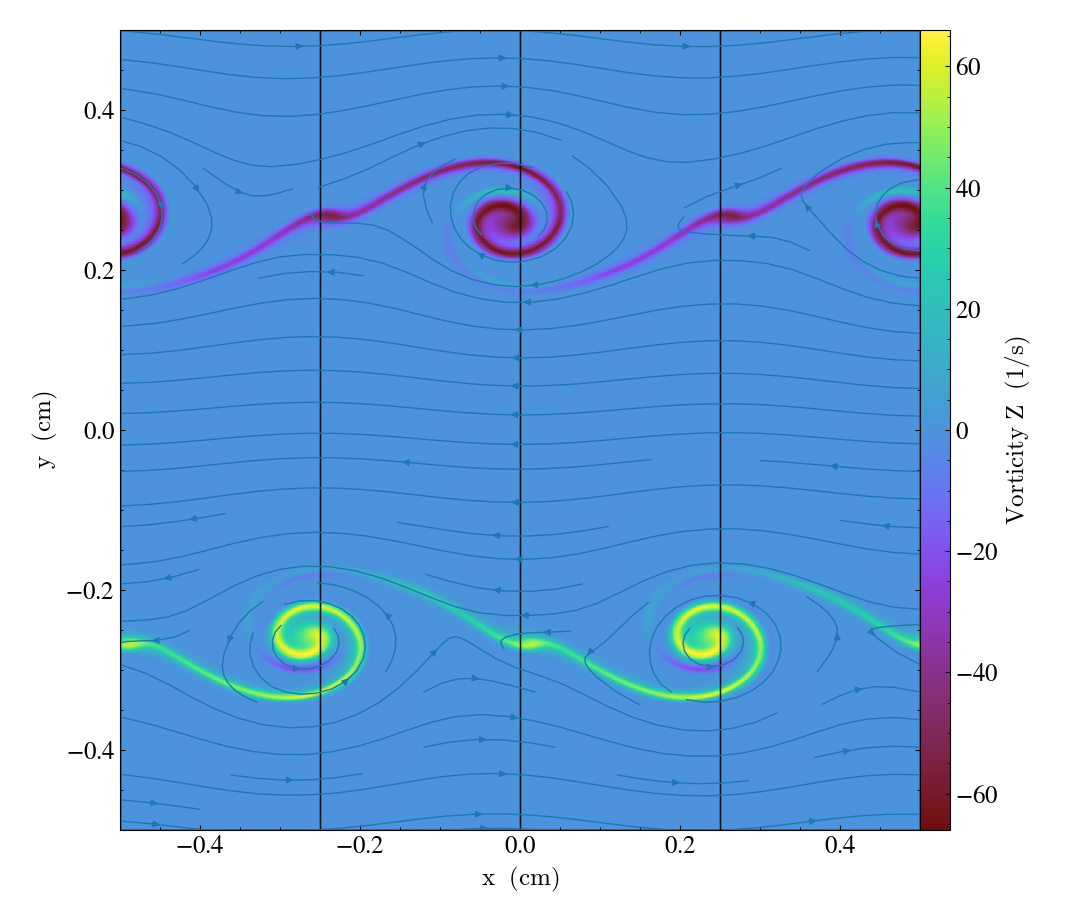

In [3]:
ds = yt.load(f"/p/project1/training2437/{user}/tera_day1/athenapk_tutorial/kh_2d_uniform/parthenon.out0.final.rhdf")
slc = yt.SlicePlot(ds, "z", ("gas", "vorticity_z"))
slc.set_log(("gas", "vorticity_z"), False)
slc.annotate_grids()
slc.annotate_streamlines(("gas", "velocity_x"), ("gas", "velocity_y"))

# see ds.derived_field_list for a full list of derived fields

## Second simulation (modifications from the command line)

All input parameters can be modified from the command line and take precedence over the data in the input file.

The variable for a given block in an input file is combined to a single argument via an additional `/`, e.g.,
```
<hydro>
reconstruction = ppm
```
turns into `hydro/reconstruction=ppm` on the command line.

### Run

Run in a terminal
```bash
$ mkdir /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_uniform_ppm
$ cd /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_uniform_ppm
$ srun -n 1 ../bin/athenaPK -i ../kh_2d_uniform/kh.in hydro/reconstruction=ppm |& tee ath.out
```

Note that other reconstruction methods (like `wenoz` or `ppm`) require larger stencils and thus need additionan ghost zones (3 for those two methods).

Can you fix this (on the command line) so that the simulation runs?

<details>
<summary>Click here for solution</summary>

```bash
$ srun -n 1 ../bin/athenaPK -i ../kh_2d_uniform/kh.in hydro/reconstruction=ppm parthenon/mesh/nghost=3 |& tee ath.out
```

</details>

### Plot

In [4]:
# adapted from https://yt-project.org/doc/cookbook/complex_plots.html#time-series-movie
ts = yt.load(f"/p/project1/training2437/{user}/tera_day1/athenapk_tutorial/kh_2d_uniform_ppm/parthenon.out0.*.rhdf")

plot = yt.SlicePlot(ts[0], "z", ("gas", "density"))
plot.set_log(("gas", "density"), False)
plot.set_zlim(("gas", "density"), 0.8, 2.1)

fig = plot.plots[("gas", "density")].figure

# animate must accept an integer frame number. We use the frame number
# to identify which dataset in the time series we want to load
def animate(i):
    ds = ts[i]
    plot._switch_ds(ds)

animation = FuncAnimation(fig, animate, frames=len(ts))
animation.save("kh_2d_uniform_ppm.mp4")

Video("kh_2d_uniform_ppm.mp4", embed=True)

## Third simulation (AMR - adaptive mesh refinement)

### Run

Again lets first start the simulation and then have a look at the input file while the simulation runs.

```bash
$ cd /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_amr
$ srun -n 1 ../bin/athenaPK -i kh.in |& tee ath.out
```

### Input file

What has changed compared to the input file for the uniform grid?

In [13]:
!git diff --no-index --word-diff --color-words /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_uniform/kh.in /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/kh_2d_amr/kh.in

diff --git a/p/project1/training2437/grete1/tera_day1/athenapk_tutorial/kh_2d_uniform/kh.in b/p/project1/training2437/grete1/tera_day1/athenapk_tutorial/kh_2d_amr/kh.in
index bb2ed27..47450dc 100644
--- a/p/project1/training2437/grete1/tera_day1/athenapk_tutorial/kh_2d_uniform/kh.in
+++ b/p/project1/training2437/grete1/tera_day1/athenapk_tutorial/kh_2d_amr/kh.in
@@ -17,17 +17,23 @@ drat   = 2               # density contrast/ratio
amp    = 0.01            # amplitude of initial vy perturbation
sigma  = 0.2             # thickness of perturbed layer


<refinement>
type                           = xyvelocity_gradient 
threshold_xyvelocity_gradient  = 0.01

<parthenon/mesh>
refinement = noneadaptive
numlevel = 3 # total number of levels
nghost = 2

nx1 = 512128
x1min = -0.5
x1max = 0.5
ix1_bc = periodic
ox1_bc = periodic

nx2 = 512128
x2min = -0.5
x2max = 0.5
ix2_bc = periodic
@@ -40,8 +46,8 @@ ix3_bc = periodic
ox3_bc = periodic

<parthenon/meshblock>
nx1=128
nx2=512nx1=16
nx2=16
nx3=1



In other words:

<details>    
<summary>Click</summary>
    
- Adaptive mesh refinement was enabled limiting the hierarchy to three levels total.  
- Mesh refinement in Parthenon based codes always happens with refinment factors of two between the levels.
- Moreover, the simulation was run at the same effective resolution (the root grid has only 1/4 of the number of cells (512->128) but two additional levels of refinement are allowed.
- Adapative mesh refinement is triggered given a threshold in the velocity gradient (this choice here is a little arbitrary and just set to match the setup in the Athena++ code paper).
- In addition, the meshblock size was adjusted (reduced) to allow for localized refinement -- otherwise, the entire domain would just refine).
</details>

### Terminal output

The output differs slightly:

```
cycle=0 time=0.0000000000000000e+00 dt=3.2952734694010211e-04 zone-cycles/wsec_step=0.00e+00 wsec_total=8.76e-02 wsec_step=2.98e+00 zone-cycles/wsec=0.00e+00 wsec_AMR=0.00e+00
---------------------- Current Mesh structure ----------------------
Number of Trees = 64
Total number of MeshBlocks = 352
Number of physical refinement levels = 2
Number of logical  refinement levels = 2
  Physical level = 0 (logical level = 0): 32 MeshBlocks, cost = 32
  Physical level = 1 (logical level = 1): 64 MeshBlocks, cost = 64
  Physical level = 2 (logical level = 2): 256 MeshBlocks, cost = 256
--------------------------------------------------------------------
cycle=1 time=3.2952734694010211e-04 dt=3.2952683932585395e-04 zone-cycles/wsec_step=3.27e+05 wsec_total=3.63e-01 wsec_step=2.75e-01 zone-cycles/wsec=3.27e+05 wsec_AMR=5.67e-06
```

First, the mesh structure is being shown (also every time it changes) and additional performance counters are given:
- `zone-cycles/wsec` differs from `zone-cycles/wsec_step` by including time for the AMR machinery (like checking for refinement)
- `wsec_AMR` for the wallclock time spent in remeshing

### Plot

In [11]:
# adapted from https://yt-project.org/doc/cookbook/complex_plots.html#time-series-movie
ts = yt.load(f"/p/project1/training2437/{user}/tera_day1/athenapk_tutorial/kh_2d_amr/parthenon.out0.*.rhdf")

plot = yt.SlicePlot(ts[0], "z", ("gas", "density"))
plot.set_log(("gas", "density"), False)
plot.set_zlim(("gas", "density"), 0.8, 2.1)
plot.annotate_grids()

fig = plot.plots[("gas", "density")].figure

# animate must accept an integer frame number. We use the frame number
# to identify which dataset in the time series we want to load
def animate(i):
    ds = ts[i]
    plot._switch_ds(ds)

animation = FuncAnimation(fig, animate, frames=len(ts))
animation.save("kh_2d_amr.mp4")

Video("kh_2d_amr.mp4", embed=True)

Bonus: Is there anything you noted about this simulation?
<details>    
<summary>Click</summary>

- Looks practically identical to the uniform grid one.  
- But performance was not worse than unigrid (we'll cover this later).
- On the up side: the snapshots/outputs got smaller (for effectively the same result).
- The final snapshot only shows two levels of refinement, i.e., the very large blocks are gone meaning that the entire root grid is refinement (and thus the refinement strategy chosen/block size is not ideal).
</details>

## Fourth simulation (3D MHD turbulence with additional outputs)

### Run

Again lets first start the simulation and then have a look at the input file while the simulation runs.

```bash
$ cd /p/project1/training2437/$USER/tera_day1/athenapk_tutorial/turb_3d_mhd_uniform
$ srun -n 1 ../bin/athenaPK -i turbulence.in |& tee ath.out
```

### The input file

What's new in this input file?

The problem generator changed (we're now running a turbulence simulation) and associated parameters.

More details on the turbulence driver can be found here: https://gitlab.com/pgrete/kathena/-/wikis/turbulence (TODO: move to GH)
```
<job>
problem_id = turbulence

<problem/turbulence>
rho0         = 1.0      # initial mean density
p0           = 1.0      # initial mean pressure
b0           = 0.01     # initial magnetic field (x-direction)
b_config     = 0        # 0 - net flux; 1 - no net flux uniform B; 2 - non net flux sin B; 4 - field loop
kpeak        = 2.0      # characteristic wavenumber
corr_time    = 1.0      # autocorrelation time of the OU forcing process
rseed        = 20190729 # random seed of the OU forcing process
sol_weight   = 1.0      # solenoidal weight of the acceleration field
accel_rms    = 0.5      # root mean square value of the acceleration field
num_modes    = 20       # number of wavemodes
```

We have additional output blocks:

First a "history" output.This results in a text file that contains additional information of the state of the simulation
(e.g., mean energy densities or Mach numbers) and the user can add problem specific fields as required.
This is often useful to keep track of a high level overview of the simulation during runtime (and typically written with higher frequency, here `dt = 0.05`, than normal outputs).
```
<parthenon/output1>
file_type  = hst        # History data dump
dt         = 0.05       # time increment between outputs
```

Second, as "hdf5" output. This allows to write a subset of the data (and also specify the variables to be written and their precision).
Internally they are identical to the "restart" outputs though the latter enforce writing data at the precision of the simulation and includes
all variables and information to recover the state of a simulation exactly.
Thus, they're often also written at higher cadence compared to restart outputs/checkpoint files.
Note, that support for writing outputs using the [openPMD](https://github.com/openPMD) standard is currently undergoing final testing and will
soon become available (and with it support using ADIOS2 rather than HDF5 for writing data).
```
<parthenon/output2>
file_type  = hdf5       # Binary data dump
variables   = prim,acc  # variables to be output
dt         = 0.25       # time increment between outputs
id         = prim
single_precision_output = true
```

The simulation is now 3D (`nx3 != 1`) and the meshblock size was also adjusted accordingly.
```
<parthenon/mesh>
...
nx3        = 128        # Number of zones in X3-direction
x3min      = 0.0        # minimum value of X3
x3max      = 1.0        # maximum value of X3
ix3_bc     = periodic   # inner-X3 boundary flag
ox3_bc     = periodic   # outer-X3 boundary flag

<parthenon/meshblock>
nx1        = 64
nx2        = 64
nx3        = 64
```

Finally, the simulation includes magnetic fields (using a generalized Lagrangian multiplier, GLM, divergence cleaning approach) and HLLD Riemann solver,
see https://github.com/parthenon-hpc-lab/athenapk/blob/main/docs/input.md for more info.

`gamma` is set close to unity to mimick an isothermal equation of state.
```
<hydro>
fluid = glmmhd
eos = adiabatic
riemann = hlld
reconstruction = plm
gamma           = 1.0001         # gamma = C_p/C_v
```

### Plot

#### yt

Note that for loading the data we now load the `prim` data (which was set by the `id` variable in the output block above).

In [ ]:
# adapted from https://yt-project.org/doc/cookbook/complex_plots.html#time-series-movie
ts = yt.load(f"/p/project1/training2437/{user}/tera_day1/athenapk_tutorial/turb_3d_mhd_uniform/parthenon.prim.*.rhdf")

plot = yt.SlicePlot(ts[0], "z", ("gas", "mach_number"))
plot.set_log(("gas", "mach_number"), False)
#plot.set_zlim(("gas", "density"), 0.8, 2.1)
#plot.annotate_grids()

fig = plot.plots[("gas", "mach_number")].figure

# animate must accept an integer frame number. We use the frame number
# to identify which dataset in the time series we want to load
def animate(i):
    ds = ts[i]
    plot._switch_ds(ds)

animation = FuncAnimation(fig, animate, frames=len(ts))
animation.save("turb_3d_mhd_uniform.mp4")

Video("turb_3d_mhd_uniform.mp4", embed=True)

#### History output

#### Histograms

## Step 4: Performance 101

### Going 3D turbulent MHD

### Static mesh refinement

### Running in parallel

### Running on the host

## Step 5: Code modifications (beyond the tutorial today)

- [ ] code structure
- [ ] ref to doc
- [ ] ask questions/discussions